In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-car-listings-features-and-prices-carscom/train.csv
/kaggle/input/used-car-listings-features-and-prices-carscom/test.csv


**TAKE AND TRIP INPUT**

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
pd.set_option('future.no_silent_downcasting', True)

cars_data_train = pd.read_csv('/kaggle/input/used-car-listings-features-and-prices-carscom/train.csv')
cars_data_test = pd.read_csv('/kaggle/input/used-car-listings-features-and-prices-carscom/test.csv')
cars_data = pd.concat([cars_data_train, cars_data_test], ignore_index=True)

def process_data(cars_data):
    cars_data.drop(columns=['engine', 
                            'transmission', 
                            'drivetrain', 
                            'min_mpg', 
                            'max_mpg', 
                            'personal_using', 
                            'turbo', 
                            'alloy_wheels', 
                            'adaptive_cruise_control', 
                            'navigation_system', 
                            'power_liftgate', 
                            'backup_camera', 
                            'keyless_start',
                            'remote_start',
                            'sunroof/moonroof',
                            'automatic_emergency_braking',
                            'stability_control',
                            'leather_seats',
                            'memory_seat',
                            'third_row_seating',
                            'apple_car_play/android_auto',
                            'bluetooth',
                            'usb_port',
                            'heated_seats',
                            'interior_color',
                            'exterior_color'
                            ], inplace=True)

    # Null check
    cars_data.isnull().sum()
    cars_data.dropna(inplace=True)
    cars_data.shape

    # Duplicate check
    cars_data.duplicated().sum()

    # Remove incorrect fuel types
    cars_data = cars_data[cars_data['fuel_type'].str.contains('E85 Flex Fuel')==False]
    cars_data = cars_data[cars_data['fuel_type'].str.contains('Unknown')==False]
    cars_data = cars_data[cars_data['fuel_type'].str.contains('B')==False]
    cars_data = cars_data[cars_data['fuel_type'].str.contains('flex_fuel')==False]
    cars_data = cars_data[cars_data['fuel_type'].str.contains('Compressed Natural Gas')==False]
    
    # Remove non numeric data from price column and convert to int, keep max 150000 price
    cars_data = cars_data[cars_data['price'].apply(lambda x: x.isnumeric())]
    cars_data['price'] = cars_data['price'].astype(int)
    cars_data['price'].quantile(0.99)
    outlier_price = 150000
    cars_data = cars_data[cars_data['price'] < outlier_price]
    
    # Adjust engine_size
    outlier_engine_size = cars_data['engine_size'].quantile(0.999)
    cars_data = cars_data[cars_data['engine_size'] < outlier_engine_size]

    def get_model_name(car_model):
        return car_model.split(' ')[0].strip(' ')

    cars_data['model'] = cars_data['model'].apply(get_model_name)
    
    cars_data.reset_index(inplace=True)
    cars_data.drop(columns=['index'], inplace=True)
    
    # Data analysis
    for col in cars_data.columns:
        print('Unique values of ' + col)
        print(cars_data[col].unique())
        print('=========================\n')
        
    return cars_data

cars_data = process_data(cars_data)
target_var = 'price'
binary_vars = [col for col in cars_data.columns if cars_data[col].nunique() == 2]
cat_vars = [ col for col in cars_data.columns if col not in binary_vars and cars_data[col].dtype == "object"]
num_vars = [ col for col in cars_data.columns if col not in binary_vars and cars_data[col].dtype in ['int64', 'float64'] and col != target_var]
binary_vars, cat_vars, num_vars

Unique values of brand
['Mazda' 'Alfa' 'Chevrolet' 'Land' 'Mitsubishi' 'FIAT' 'Kia' 'Audi'
 'Honda' 'Jeep' 'Mercedes-Benz' 'Porsche' 'MINI' 'Nissan' 'Jaguar'
 'Toyota' 'BMW' 'Lexus' 'Hyundai' 'Maserati' 'Volvo' 'Cadillac' 'Ford'
 'Volkswagen' 'Suzuki']

Unique values of model
['CX-9' 'Romeo' 'Silverado' 'Rover' 'Outlander' '500' 'Carnival' 'SQ5'
 'Pilot' 'Grand' 'GL-Class' '968' 'Hardtop' 'Sentra' 'CX-3' 'Niro'
 'F-PACE' 'Sorento' 'Convertible' 'A8' 'Avalon' 'X3' '124' 'Tahoe' 'Titan'
 'Prius' 'NX' 'Countryman' 'Tucson' 'Levante' 'S90' 'CX-5' 'Cherokee'
 'XC90' 'XK' '128' 'Pathfinder' '944' 'GLE' 'Cooper' 'XT4' 'Escalade'
 'Telluride' 'NV' 'Q5' '228' 'Edge' 'Golf' '500C' 'Civic' 'Q3' '840'
 'Blazer' 'Insight' 'Bronco' 'Accord' 'Explorer' '500L' 'M340' 'Eclipse'
 'Tundra' 'Cayenne' 'CLS' 'A7' 'Frontier' 'RX' 'Wrangler' 'Taos' 'F-TYPE'
 'IS' 'Corolla' 'Tacoma' 'Quattroporte' '500X' 'Ghibli' 'Mazda6' 'Optima'
 'E-Class' 'Maybach' 'Tiguan' 'XF' 'Macan' 'Panamera' 'XE' 'XC40' 'CTS-V'
 'CX-3

(['automatic_transmission', 'damaged', 'first_owner'],
 ['brand', 'model', 'fuel_type'],
 ['year', 'mileage', 'engine_size'])

In [3]:
!pip install feature-engine

**PREPROCESS**

In [4]:
# Train test split

train, valid = train_test_split(cars_data, test_size=0.2, random_state=0, shuffle=True)
X_train = train.drop('price', axis=1)
y_train = train['price']

X_valid = valid.drop('price', axis=1)
y_valid = valid['price']

len(X_train), len(X_valid)

(17116, 4279)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor
import optuna

preprocessor_pipe = Pipeline([
    ("num_var_imputer", MeanMedianImputer(imputation_method="median", variables=num_vars+binary_vars)),
    ("cat_var_imputer", CategoricalImputer(imputation_method="frequent", variables=cat_vars)),
    ("rare_label_encoder", RareLabelEncoder(
    tol=0.03, n_categories=2, variables=cat_vars)),
    ("one_hot_encoder", OneHotEncoder(
    variables=cat_vars, ignore_format=True)),
    ("scaling", StandardScaler()),
])

X_train_transformed = preprocessor_pipe.fit_transform(X_train)
X_valid_transformed = preprocessor_pipe.transform(X_valid)

dtrain = xgb.DMatrix(X_train_transformed, label=y_train)
dvalid = xgb.DMatrix(X_valid_transformed, label=y_valid)

def objective(trial):
        
    params = {
        "verbosity": 0, 
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.6, log=True),
        "subsample": trial.suggest_float("subsample", 0.4, 0.8, log=True),
        "alpha": trial.suggest_float("alpha", 0.01, 10.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log=True),
        "min_child_weight": trial.suggest_float("min_child_weight", 10, 1000, log=True),
        "seed": 42
    }


    booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dvalid, 'validation')],
    early_stopping_rounds=25
    )

    y_pred = booster.predict(dvalid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)

    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2024-05-08 15:23:19,674] A new study created in memory with name: no-name-f781147b-8bfb-4f9d-90a4-0c9553705964


[0]	validation-rmse:19888.66812
[1]	validation-rmse:19805.16186
[2]	validation-rmse:19367.36232
[3]	validation-rmse:18826.85894
[4]	validation-rmse:18784.87426
[5]	validation-rmse:18060.44062
[6]	validation-rmse:17403.93108
[7]	validation-rmse:17292.16256
[8]	validation-rmse:17201.65155
[9]	validation-rmse:16870.02037
[10]	validation-rmse:16538.02387
[11]	validation-rmse:16423.66741
[12]	validation-rmse:16337.48246
[13]	validation-rmse:15944.00747
[14]	validation-rmse:15624.52303
[15]	validation-rmse:15349.42241


/tmp/ipykernel_95/2227624422.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),


[16]	validation-rmse:15063.52203
[17]	validation-rmse:14544.00498
[18]	validation-rmse:14328.38080
[19]	validation-rmse:13893.62913
[20]	validation-rmse:13495.02540
[21]	validation-rmse:13276.30133
[22]	validation-rmse:13236.90396
[23]	validation-rmse:13090.28340
[24]	validation-rmse:12940.45599
[25]	validation-rmse:12895.97803
[26]	validation-rmse:12523.57385
[27]	validation-rmse:12503.47045
[28]	validation-rmse:12141.86842
[29]	validation-rmse:11856.21648
[30]	validation-rmse:11726.33125
[31]	validation-rmse:11594.25155
[32]	validation-rmse:11506.22917
[33]	validation-rmse:11414.87503
[34]	validation-rmse:11402.44993
[35]	validation-rmse:11391.54013
[36]	validation-rmse:11363.41619
[37]	validation-rmse:11105.05594
[38]	validation-rmse:11036.12264
[39]	validation-rmse:10889.48953
[40]	validation-rmse:10817.15058
[41]	validation-rmse:10709.32857
[42]	validation-rmse:10648.02265
[43]	validation-rmse:10583.97191
[44]	validation-rmse:10565.59195
[45]	validation-rmse:10473.25367
[46]	valid

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-08 15:23:25,980] Trial 0 finished with value: 7585.937729093604 and parameters: {'n_estimators': 150, 'max_depth': 51, 'learning_rate': 0.06119241111972177, 'colsample_bytree': 0.3023972794055764, 'subsample': 0.7309698383658645, 'alpha': 7.203568338827841, 'lambda': 0.021733926629071393, 'gamma': 0.0016608847929032266, 'min_child_weight': 38.129720410196825}. Best is trial 0 with value: 7585.937729093604.


[0]	validation-rmse:20352.78539
[1]	validation-rmse:20306.90810
[2]	validation-rmse:20250.15230
[3]	validation-rmse:20204.40985
[4]	validation-rmse:20194.43371
[5]	validation-rmse:20110.27851
[6]	validation-rmse:20023.73079
[7]	validation-rmse:19933.06100
[8]	validation-rmse:19912.71530
[9]	validation-rmse:19858.77341
[10]	validation-rmse:19805.10101
[11]	validation-rmse:19762.83284
[12]	validation-rmse:19741.81061
[13]	validation-rmse:19689.23546
[14]	validation-rmse:19644.14186
[15]	validation-rmse:19589.94554
[16]	validation-rmse:19510.91641
[17]	validation-rmse:19423.67981
[18]	validation-rmse:19371.63449
[19]	validation-rmse:19287.11396
[20]	validation-rmse:19210.81541
[21]	validation-rmse:19127.13032
[22]	validation-rmse:19079.18331
[23]	validation-rmse:19029.51252
[24]	validation-rmse:18991.71572
[25]	validation-rmse:18984.45171


/tmp/ipykernel_95/2227624422.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),


[26]	validation-rmse:18900.79213
[27]	validation-rmse:18854.78435
[28]	validation-rmse:18781.81457
[29]	validation-rmse:18702.13983
[30]	validation-rmse:18655.21803
[31]	validation-rmse:18609.62706
[32]	validation-rmse:18574.28496
[33]	validation-rmse:18530.73380
[34]	validation-rmse:18496.58457
[35]	validation-rmse:18471.41889
[36]	validation-rmse:18454.44856
[37]	validation-rmse:18378.48398
[38]	validation-rmse:18334.19639
[39]	validation-rmse:18290.66571
[40]	validation-rmse:18261.57727
[41]	validation-rmse:18219.03045
[42]	validation-rmse:18185.71456
[43]	validation-rmse:18179.60669
[44]	validation-rmse:18172.99025
[45]	validation-rmse:18100.24358
[46]	validation-rmse:18068.34362
[47]	validation-rmse:18063.00870
[48]	validation-rmse:17994.42057
[49]	validation-rmse:17954.74452
[50]	validation-rmse:17923.53779
[51]	validation-rmse:17892.43653
[52]	validation-rmse:17821.29783
[53]	validation-rmse:17785.85083
[54]	validation-rmse:17715.74914
[55]	validation-rmse:17678.29646
[56]	valid

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-08 15:23:33,764] Trial 1 finished with value: 9735.568738599506 and parameters: {'n_estimators': 450, 'max_depth': 27, 'learning_rate': 0.007914869487992228, 'colsample_bytree': 0.4205543858279882, 'subsample': 0.7954458330423158, 'alpha': 0.08914350104071067, 'lambda': 0.0004991472239728723, 'gamma': 0.03725885578429666, 'min_child_weight': 521.5100538681793}. Best is trial 0 with value: 7585.937729093604.


[0]	validation-rmse:20365.90128
[1]	validation-rmse:20358.56402
[2]	validation-rmse:20317.83345
[3]	validation-rmse:20304.13477
[4]	validation-rmse:20300.57574
[5]	validation-rmse:20230.72623
[6]	validation-rmse:20191.28840
[7]	validation-rmse:20178.76944
[8]	validation-rmse:20170.18337
[9]	validation-rmse:20158.47983
[10]	validation-rmse:20116.91605
[11]	validation-rmse:20104.00190
[12]	validation-rmse:20093.38504
[13]	validation-rmse:20083.45442
[14]	validation-rmse:20047.92613
[15]	validation-rmse:20005.90906
[16]	validation-rmse:20000.74699
[17]	validation-rmse:19925.81930
[18]	validation-rmse:19883.73152
[19]	validation-rmse:19841.72480
[20]	validation-rmse:19775.02440


/tmp/ipykernel_95/2227624422.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),


[21]	validation-rmse:19734.90440
[22]	validation-rmse:19726.61608
[23]	validation-rmse:19688.57143
[24]	validation-rmse:19651.78609
[25]	validation-rmse:19641.13969
[26]	validation-rmse:19568.70753
[27]	validation-rmse:19564.99604
[28]	validation-rmse:19493.64822
[29]	validation-rmse:19460.94880
[30]	validation-rmse:19419.33452
[31]	validation-rmse:19385.31275
[32]	validation-rmse:19353.06383
[33]	validation-rmse:19315.73336
[34]	validation-rmse:19312.10388
[35]	validation-rmse:19308.56636
[36]	validation-rmse:19303.95955
[37]	validation-rmse:19233.13951
[38]	validation-rmse:19202.12591
[39]	validation-rmse:19153.50247
[40]	validation-rmse:19139.60188
[41]	validation-rmse:19129.26231
[42]	validation-rmse:19097.10949
[43]	validation-rmse:19078.67804
[44]	validation-rmse:19071.48174
[45]	validation-rmse:19038.25337
[46]	validation-rmse:19003.24602
[47]	validation-rmse:18993.75137
[48]	validation-rmse:18961.87993
[49]	validation-rmse:18925.37576
[50]	validation-rmse:18914.72959
[51]	valid

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-08 15:23:47,421] Trial 2 finished with value: 9524.50281676126 and parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.005193196764788691, 'colsample_bytree': 0.24574108675710982, 'subsample': 0.564947292134051, 'alpha': 2.2278965633772465, 'lambda': 9.082841561033309e-06, 'gamma': 3.505919751055917e-08, 'min_child_weight': 22.541140120656173}. Best is trial 0 with value: 7585.937729093604.


[0]	validation-rmse:20112.92327
[1]	validation-rmse:19882.95339
[2]	validation-rmse:19443.97027
[3]	validation-rmse:19225.71644
[4]	validation-rmse:19023.36822
[5]	validation-rmse:18656.73517
[6]	validation-rmse:18306.08994
[7]	validation-rmse:17943.55767
[8]	validation-rmse:17781.05891
[9]	validation-rmse:17581.63411
[10]	validation-rmse:17394.70351
[11]	validation-rmse:17214.76279
[12]	validation-rmse:17050.53563
[13]	validation-rmse:16890.59885
[14]	validation-rmse:16583.62440
[15]	validation-rmse:16298.33938
[16]	validation-rmse:16039.15617
[17]	validation-rmse:15793.34568
[18]	validation-rmse:15665.30072
[19]	validation-rmse:15436.55540
[20]	validation-rmse:15223.38920
[21]	validation-rmse:15014.53754


/tmp/ipykernel_95/2227624422.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),


[22]	validation-rmse:14915.63158
[23]	validation-rmse:14823.47941
[24]	validation-rmse:14758.30773
[25]	validation-rmse:14743.63747
[26]	validation-rmse:14567.31537
[27]	validation-rmse:14489.48679
[28]	validation-rmse:14330.80999
[29]	validation-rmse:14181.21649
[30]	validation-rmse:14115.94799
[31]	validation-rmse:14007.31348
[32]	validation-rmse:13962.32328
[33]	validation-rmse:13818.96831
[34]	validation-rmse:13700.67198
[35]	validation-rmse:13700.70438
[36]	validation-rmse:13699.87163
[37]	validation-rmse:13572.23308
[38]	validation-rmse:13457.75096
[39]	validation-rmse:13411.59276
[40]	validation-rmse:13411.26344
[41]	validation-rmse:13336.58709
[42]	validation-rmse:13306.01113
[43]	validation-rmse:13236.99079
[44]	validation-rmse:13206.80373
[45]	validation-rmse:13116.13865
[46]	validation-rmse:13082.01819
[47]	validation-rmse:13005.82739
[48]	validation-rmse:12935.60473
[49]	validation-rmse:12905.84409
[50]	validation-rmse:12886.77655
[51]	validation-rmse:12868.80247
[52]	valid

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-08 15:23:55,060] Trial 3 finished with value: 10934.876857090781 and parameters: {'n_estimators': 300, 'max_depth': 44, 'learning_rate': 0.04155781174279082, 'colsample_bytree': 0.542717162153568, 'subsample': 0.513177781578264, 'alpha': 0.8656958409003238, 'lambda': 0.004421899836152477, 'gamma': 2.4840910710595367e-08, 'min_child_weight': 549.7431149434607}. Best is trial 0 with value: 7585.937729093604.


[0]	validation-rmse:20155.96351
[1]	validation-rmse:19919.65600
[2]	validation-rmse:19699.20571
[3]	validation-rmse:19415.63581
[4]	validation-rmse:19340.86083
[5]	validation-rmse:18984.11303
[6]	validation-rmse:18652.20052
[7]	validation-rmse:18323.59893
[8]	validation-rmse:18257.49699
[9]	validation-rmse:18062.37274
[10]	validation-rmse:17854.51616
[11]	validation-rmse:17680.56560
[12]	validation-rmse:17616.72565
[13]	validation-rmse:17383.78058
[14]	validation-rmse:17091.54624
[15]	validation-rmse:16784.48532


/tmp/ipykernel_95/2227624422.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),


[16]	validation-rmse:16504.39295
[17]	validation-rmse:16199.95173
[18]	validation-rmse:16052.46387
[19]	validation-rmse:15778.14522
[20]	validation-rmse:15534.03505
[21]	validation-rmse:15296.34357
[22]	validation-rmse:15160.10213
[23]	validation-rmse:15034.55905
[24]	validation-rmse:14859.58197
[25]	validation-rmse:14814.77352
[26]	validation-rmse:14563.97654
[27]	validation-rmse:14419.12882
[28]	validation-rmse:14191.77043
[29]	validation-rmse:13992.91007
[30]	validation-rmse:13872.65267
[31]	validation-rmse:13752.16393
[32]	validation-rmse:13667.57121
[33]	validation-rmse:13577.58277
[34]	validation-rmse:13451.97703
[35]	validation-rmse:13396.16577
[36]	validation-rmse:13364.04926
[37]	validation-rmse:13173.43016
[38]	validation-rmse:13002.05801
[39]	validation-rmse:12888.11249
[40]	validation-rmse:12833.25441
[41]	validation-rmse:12732.70702
[42]	validation-rmse:12659.92154
[43]	validation-rmse:12604.02282
[44]	validation-rmse:12573.82341
[45]	validation-rmse:12427.50542
[46]	valid

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-08 15:24:04,529] Trial 4 finished with value: 7500.401545999901 and parameters: {'n_estimators': 300, 'max_depth': 38, 'learning_rate': 0.02733049828430494, 'colsample_bytree': 0.4412081171238933, 'subsample': 0.4874202734087946, 'alpha': 0.1969257420522934, 'lambda': 0.009750027979854383, 'gamma': 0.0031744260368565297, 'min_child_weight': 21.98189891571424}. Best is trial 4 with value: 7500.401545999901.


[0]	validation-rmse:20309.10366
[1]	validation-rmse:20289.87345
[2]	validation-rmse:20189.26298
[3]	validation-rmse:20110.49436
[4]	validation-rmse:20098.71560
[5]	validation-rmse:19935.91363
[6]	validation-rmse:19779.30603
[7]	validation-rmse:19749.97417
[8]	validation-rmse:19724.57560
[9]	validation-rmse:19631.82051
[10]	validation-rmse:19540.87257
[11]	validation-rmse:19517.74809
[12]	validation-rmse:19487.86939
[13]	validation-rmse:19378.25395
[14]	validation-rmse:19304.49534
[15]	validation-rmse:19217.37666
[16]	validation-rmse:19144.49291
[17]	validation-rmse:18983.68052
[18]	validation-rmse:18896.33891
[19]	validation-rmse:18741.04896
[20]	validation-rmse:18602.07879
[21]	validation-rmse:18519.81302
[22]	validation-rmse:18500.36671


/tmp/ipykernel_95/2227624422.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),


[23]	validation-rmse:18422.65504
[24]	validation-rmse:18361.33508
[25]	validation-rmse:18335.55018
[26]	validation-rmse:18192.22577
[27]	validation-rmse:18182.38448
[28]	validation-rmse:18051.18035
[29]	validation-rmse:17910.85235
[30]	validation-rmse:17835.22473
[31]	validation-rmse:17771.40344
[32]	validation-rmse:17715.04096
[33]	validation-rmse:17645.15891
[34]	validation-rmse:17635.23684
[35]	validation-rmse:17624.67964
[36]	validation-rmse:17604.53277
[37]	validation-rmse:17472.20829
[38]	validation-rmse:17419.17722
[39]	validation-rmse:17328.31924
[40]	validation-rmse:17288.13394
[41]	validation-rmse:17217.56984
[42]	validation-rmse:17166.69379
[43]	validation-rmse:17122.78581
[44]	validation-rmse:17095.77931
[45]	validation-rmse:17036.99622
[46]	validation-rmse:16982.28540
[47]	validation-rmse:16954.13834
[48]	validation-rmse:16906.77830
[49]	validation-rmse:16826.77635
[50]	validation-rmse:16774.33376
[51]	validation-rmse:16728.16935
[52]	validation-rmse:16609.72800
[53]	valid

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-08 15:24:12,787] Trial 5 finished with value: 9154.756210958676 and parameters: {'n_estimators': 500, 'max_depth': 92, 'learning_rate': 0.01397321801953692, 'colsample_bytree': 0.30309248351566603, 'subsample': 0.46113162562885146, 'alpha': 0.044554262286657, 'lambda': 0.04709380749948997, 'gamma': 2.5088215315277217e-06, 'min_child_weight': 183.37057560151146}. Best is trial 4 with value: 7500.401545999901.


[0]	validation-rmse:20349.44587
[1]	validation-rmse:20339.51685
[2]	validation-rmse:20284.02809
[3]	validation-rmse:20264.80748
[4]	validation-rmse:20260.04317
[5]	validation-rmse:20159.49140
[6]	validation-rmse:20106.26096
[7]	validation-rmse:20089.16713
[8]	validation-rmse:20077.55421
[9]	validation-rmse:20062.03097
[10]	validation-rmse:20005.91182
[11]	validation-rmse:19988.62375
[12]	validation-rmse:19974.56041
[13]	validation-rmse:19960.98206
[14]	validation-rmse:19911.75809
[15]	validation-rmse:19855.04794
[16]	validation-rmse:19848.08154
[17]	validation-rmse:19744.89501
[18]	validation-rmse:19688.68703
[19]	validation-rmse:19628.75545


/tmp/ipykernel_95/2227624422.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),


[20]	validation-rmse:19533.97336
[21]	validation-rmse:19479.24473
[22]	validation-rmse:19468.04263
[23]	validation-rmse:19417.03787
[24]	validation-rmse:19367.87015
[25]	validation-rmse:19353.93036
[26]	validation-rmse:19255.71720
[27]	validation-rmse:19251.02061
[28]	validation-rmse:19149.50853
[29]	validation-rmse:19104.22647
[30]	validation-rmse:19048.25110
[31]	validation-rmse:19003.21183
[32]	validation-rmse:18960.34394
[33]	validation-rmse:18910.83659
[34]	validation-rmse:18906.24444
[35]	validation-rmse:18901.48765
[36]	validation-rmse:18895.34409
[37]	validation-rmse:18801.15746
[38]	validation-rmse:18760.34617
[39]	validation-rmse:18697.07921
[40]	validation-rmse:18678.92267
[41]	validation-rmse:18665.73609
[42]	validation-rmse:18624.34488
[43]	validation-rmse:18600.08771
[44]	validation-rmse:18590.82793
[45]	validation-rmse:18546.80371
[46]	validation-rmse:18501.47754
[47]	validation-rmse:18489.45218
[48]	validation-rmse:18447.86701
[49]	validation-rmse:18400.79685
[50]	valid

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-08 15:24:35,814] Trial 6 finished with value: 8685.804021229158 and parameters: {'n_estimators': 350, 'max_depth': 13, 'learning_rate': 0.007048303261617238, 'colsample_bytree': 0.23810593922899795, 'subsample': 0.7981491904635024, 'alpha': 2.0261807711059188, 'lambda': 2.5163410760918266e-07, 'gamma': 0.004765467160122512, 'min_child_weight': 13.308163473104859}. Best is trial 4 with value: 7500.401545999901.


[0]	validation-rmse:19819.55536
[1]	validation-rmse:19337.43468
[2]	validation-rmse:18852.37308
[3]	validation-rmse:18240.60243
[4]	validation-rmse:18178.44299
[5]	validation-rmse:17415.14379
[6]	validation-rmse:16742.02592
[7]	validation-rmse:16623.11455
[8]	validation-rmse:16502.80725
[9]	validation-rmse:16146.95756
[10]	validation-rmse:15801.24983
[11]	validation-rmse:15516.43197
[12]	validation-rmse:15417.60971
[13]	validation-rmse:15002.57887
[14]	validation-rmse:14706.86229
[15]	validation-rmse:14447.83770
[16]	validation-rmse:13981.77987
[17]	validation-rmse:13446.32878
[18]	validation-rmse:13259.89220


/tmp/ipykernel_95/2227624422.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),


[19]	validation-rmse:12870.58740
[20]	validation-rmse:12527.20504
[21]	validation-rmse:12332.69680
[22]	validation-rmse:12207.46145
[23]	validation-rmse:12078.64279
[24]	validation-rmse:11967.21999
[25]	validation-rmse:11930.05660
[26]	validation-rmse:11604.93476
[27]	validation-rmse:11574.35708
[28]	validation-rmse:11277.33793
[29]	validation-rmse:11050.40583
[30]	validation-rmse:10947.27854
[31]	validation-rmse:10837.45541
[32]	validation-rmse:10765.29464
[33]	validation-rmse:10693.43396
[34]	validation-rmse:10559.57714
[35]	validation-rmse:10542.68988
[36]	validation-rmse:10519.68034
[37]	validation-rmse:10300.70578
[38]	validation-rmse:10239.44771
[39]	validation-rmse:10124.60622
[40]	validation-rmse:10065.57123
[41]	validation-rmse:9976.39325
[42]	validation-rmse:9939.85524
[43]	validation-rmse:9882.72962
[44]	validation-rmse:9867.63967
[45]	validation-rmse:9786.27465
[46]	validation-rmse:9746.28070
[47]	validation-rmse:9732.04801
[48]	validation-rmse:9624.61384
[49]	validation-rm

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-08 15:24:45,025] Trial 7 finished with value: 7538.385419231219 and parameters: {'n_estimators': 250, 'max_depth': 82, 'learning_rate': 0.06854729320877553, 'colsample_bytree': 0.36782218101410913, 'subsample': 0.5790696714919635, 'alpha': 1.7561803695592935, 'lambda': 9.933820306514771e-05, 'gamma': 2.411658235792636e-06, 'min_child_weight': 43.42824627465657}. Best is trial 4 with value: 7500.401545999901.


[0]	validation-rmse:20343.40121
[1]	validation-rmse:20290.58449
[2]	validation-rmse:20223.46193
[3]	validation-rmse:20170.01056
[4]	validation-rmse:20158.70425
[5]	validation-rmse:20063.65365
[6]	validation-rmse:19967.34737
[7]	validation-rmse:19865.64152
[8]	validation-rmse:19865.10405
[9]	validation-rmse:19803.34640
[10]	validation-rmse:19742.39613
[11]	validation-rmse:19679.54535
[12]	validation-rmse:19679.54350
[13]	validation-rmse:19619.31532
[14]	validation-rmse:19519.21027
[15]	validation-rmse:19420.07326
[16]	validation-rmse:19331.56437
[17]	validation-rmse:19238.09195
[18]	validation-rmse:19180.15698
[19]	validation-rmse:19085.84647
[20]	validation-rmse:19001.37063
[21]	validation-rmse:18905.73433
[22]	validation-rmse:18851.47575
[23]	validation-rmse:18796.38866
[24]	validation-rmse:18755.03681
[25]	validation-rmse:18746.62505


/tmp/ipykernel_95/2227624422.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),


[26]	validation-rmse:18657.37955
[27]	validation-rmse:18607.17305
[28]	validation-rmse:18525.96237
[29]	validation-rmse:18436.35783
[30]	validation-rmse:18383.89968
[31]	validation-rmse:18332.44085
[32]	validation-rmse:18293.98341
[33]	validation-rmse:18244.76760
[34]	validation-rmse:18206.47991
[35]	validation-rmse:18205.92431
[36]	validation-rmse:18203.68769
[37]	validation-rmse:18122.01636
[38]	validation-rmse:18042.88673
[39]	validation-rmse:17995.70565
[40]	validation-rmse:17994.01744
[41]	validation-rmse:17945.85434
[42]	validation-rmse:17910.36567
[43]	validation-rmse:17903.82186
[44]	validation-rmse:17895.75110
[45]	validation-rmse:17812.99917
[46]	validation-rmse:17778.61585
[47]	validation-rmse:17735.96008
[48]	validation-rmse:17665.73483
[49]	validation-rmse:17623.61675
[50]	validation-rmse:17590.49666
[51]	validation-rmse:17557.54294
[52]	validation-rmse:17483.37661
[53]	validation-rmse:17447.02176
[54]	validation-rmse:17373.05109
[55]	validation-rmse:17331.34314
[56]	valid

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-08 15:24:54,577] Trial 8 finished with value: 11191.829974927427 and parameters: {'n_estimators': 200, 'max_depth': 71, 'learning_rate': 0.00924489755504997, 'colsample_bytree': 0.4695875742550959, 'subsample': 0.4007122497995127, 'alpha': 0.16968961542064842, 'lambda': 1.920160530211827e-06, 'gamma': 2.64855276527321e-05, 'min_child_weight': 345.72060130092405}. Best is trial 4 with value: 7500.401545999901.


[0]	validation-rmse:20359.97908
[1]	validation-rmse:20271.34126
[2]	validation-rmse:20182.81201
[3]	validation-rmse:20120.79396
[4]	validation-rmse:20069.12380
[5]	validation-rmse:19988.41378
[6]	validation-rmse:19908.43073
[7]	validation-rmse:19823.51926
[8]	validation-rmse:19775.70167
[9]	validation-rmse:19715.78173
[10]	validation-rmse:19665.14888
[11]	validation-rmse:19611.38287
[12]	validation-rmse:19566.04170
[13]	validation-rmse:19482.31297
[14]	validation-rmse:19398.80051
[15]	validation-rmse:19316.36568
[16]	validation-rmse:19240.09902
[17]	validation-rmse:19156.84001
[18]	validation-rmse:19096.95777


/tmp/ipykernel_95/2227624422.py:31: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  "n_estimators": trial.suggest_int('n_estimators', 50, 500, 50),


[19]	validation-rmse:19015.80171
[20]	validation-rmse:18942.94457
[21]	validation-rmse:18863.20273
[22]	validation-rmse:18819.19695
[23]	validation-rmse:18771.54716
[24]	validation-rmse:18706.68090
[25]	validation-rmse:18667.59719
[26]	validation-rmse:18588.57394
[27]	validation-rmse:18534.12181
[28]	validation-rmse:18459.90091
[29]	validation-rmse:18385.54606
[30]	validation-rmse:18342.06154
[31]	validation-rmse:18298.87211
[32]	validation-rmse:18261.87017
[33]	validation-rmse:18187.39498
[34]	validation-rmse:18117.87302
[35]	validation-rmse:18090.48182
[36]	validation-rmse:18073.87780
[37]	validation-rmse:18001.58146
[38]	validation-rmse:17929.60254
[39]	validation-rmse:17877.13393
[40]	validation-rmse:17846.37804
[41]	validation-rmse:17806.74363
[42]	validation-rmse:17742.56874
[43]	validation-rmse:17699.51330
[44]	validation-rmse:17660.42974
[45]	validation-rmse:17590.13553
[46]	validation-rmse:17549.10423
[47]	validation-rmse:17485.85969
[48]	validation-rmse:17423.38576
[49]	valid

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-08 15:25:04,491] Trial 9 finished with value: 8419.069434754625 and parameters: {'n_estimators': 450, 'max_depth': 50, 'learning_rate': 0.0065453281453043705, 'colsample_bytree': 0.5797182584450244, 'subsample': 0.5318947015185922, 'alpha': 8.76229806483385, 'lambda': 1.9273029465245765e-05, 'gamma': 3.075035493743531e-07, 'min_child_weight': 97.92647877589505}. Best is trial 4 with value: 7500.401545999901.


In [6]:
def eval_model(y_valid, y_pred):
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    print(f"RMSE: {rmse:.3f}")
    r2= r2_score(y_valid, y_pred)
    print(f"r2_score: {r2:.3f}")
    
xgb_best_param = study.best_params
xgb_best_score = study.best_value
print(xgb_best_score)
    
xgb_best_param = dict(**xgb_best_param, seed=42)

booster = xgb.train(
    params=xgb_best_param,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dvalid, 'validation')],
    early_stopping_rounds=25
    )

y_pred = booster.predict(dvalid)
eval_model(y_valid, y_pred)

7500.401545999901
[0]	validation-rmse:20155.96351
[1]	validation-rmse:19919.65600
[2]	validation-rmse:19699.20571
[3]	validation-rmse:19415.63581
[4]	validation-rmse:19340.86083
[5]	validation-rmse:18984.11303
[6]	validation-rmse:18652.20052
[7]	validation-rmse:18323.59893
[8]	validation-rmse:18257.49699
[9]	validation-rmse:18062.37274
[10]	validation-rmse:17854.51616
[11]	validation-rmse:17680.56560
[12]	validation-rmse:17616.72565
[13]	validation-rmse:17383.78058
[14]	validation-rmse:17091.54624
[15]	validation-rmse:16784.48532
[16]	validation-rmse:16504.39295
[17]	validation-rmse:16199.95173
[18]	validation-rmse:16052.46387
[19]	validation-rmse:15778.14522
[20]	validation-rmse:15534.03505
[21]	validation-rmse:15296.34357
[22]	validation-rmse:15160.10213
[23]	validation-rmse:15034.55905
[24]	validation-rmse:14859.58197
[25]	validation-rmse:14814.77352
[26]	validation-rmse:14563.97654
[27]	validation-rmse:14419.12882
[28]	validation-rmse:14191.77043
[29]	validation-rmse:13992.91007
[3

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


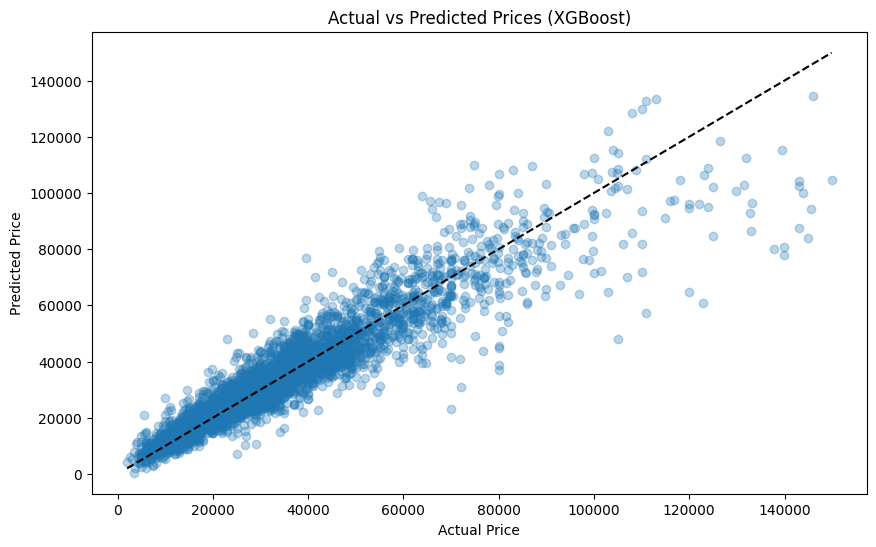

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(y_valid, y_pred, alpha=0.3)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (XGBoost)')
plt.show()